In [295]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
import pandas as pd
import numpy as np
import importlib

import helper_functions
importlib.reload(helper_functions)

import helper_functions.utils
import helper_functions.flood_utils
import helper_functions.plot_utils
import helper_functions.routing.driving
import helper_functions.routing.dryRouting
import helper_functions.routing.floodedRouting
import helper_functions.routing.publicTransit

importlib.reload(helper_functions.utils)
importlib.reload(helper_functions.flood_utils)
importlib.reload(helper_functions.plot_utils)
importlib.reload(helper_functions.routing.driving)
importlib.reload(helper_functions.routing.dryRouting)
importlib.reload(helper_functions.routing.floodedRouting)
importlib.reload(helper_functions.routing.publicTransit)

import helper_functions.utils as utils
import helper_functions.flood_utils as flood_utils
import helper_functions.plot_utils as plot_utils
import helper_functions.routing.driving as driving
import helper_functions.routing.dryRouting as dryRouting
import helper_functions.routing.floodedRouting as floodedRouting
import helper_functions.routing.publicTransit as publicTransit

# Import car and bus network

In [110]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_car_network.graphml"
G_car = ox.load_graphml(os.path.join(save_dir,filename))

save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_bus_network.graphml"
G_bus = ox.load_graphml(os.path.join(save_dir,filename))

### Import planning area

<class 'geopandas.geodataframe.GeoDataFrame'>


,Name,Description,geometry,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...",BEDOK,BD,N,EAST REGION,ER,5F00E6FF084F3364,20191223152014
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...",BOON LAY,BL,N,WEST REGION,WR,C96AED188C00B2FC,20191223152014
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...",BUKIT BATOK,BK,N,WEST REGION,WR,3BEC4C829160F28A,20191223152014
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...",BUKIT MERAH,BM,N,CENTRAL REGION,CR,4850795BB0B6A4F7,20191223152014
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...",BUKIT PANJANG,BP,N,WEST REGION,WR,656F87D23D6DAB02,20191223152014


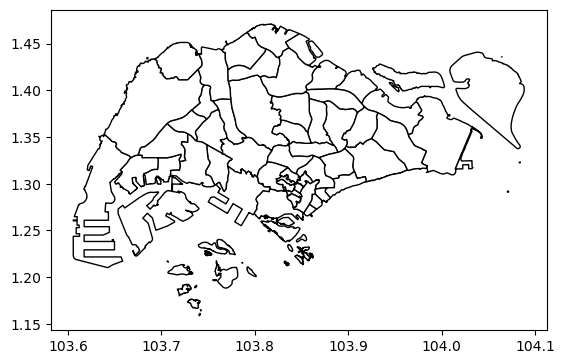

In [161]:
# planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019_PlanningArea_Fixed.shp")
# planningArea_shp.plot(fc='white',ec='k')

from bs4 import BeautifulSoup 
planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

### Import work cluster

In [19]:
workplace_cluster = pd.read_csv(r"data\workplace_cluster.csv")
workplace_cluster
workplace_nodes = ox.distance.nearest_nodes(G_bus, X=workplace_cluster.longitude.to_list(), Y=workplace_cluster.latitude.to_list())
workplace_nodes
workplace_cluster['node_ID'] = workplace_nodes
workplace_cluster.head()

,latitude,longitude,node_ID
0,1.320935,103.894151,258305981
1,1.327584,103.703464,4494048581
2,1.448092,103.810287,4607055587
3,1.284441,103.842959,246800416
4,1.295068,103.629310,842360753


# Car dry isochrone

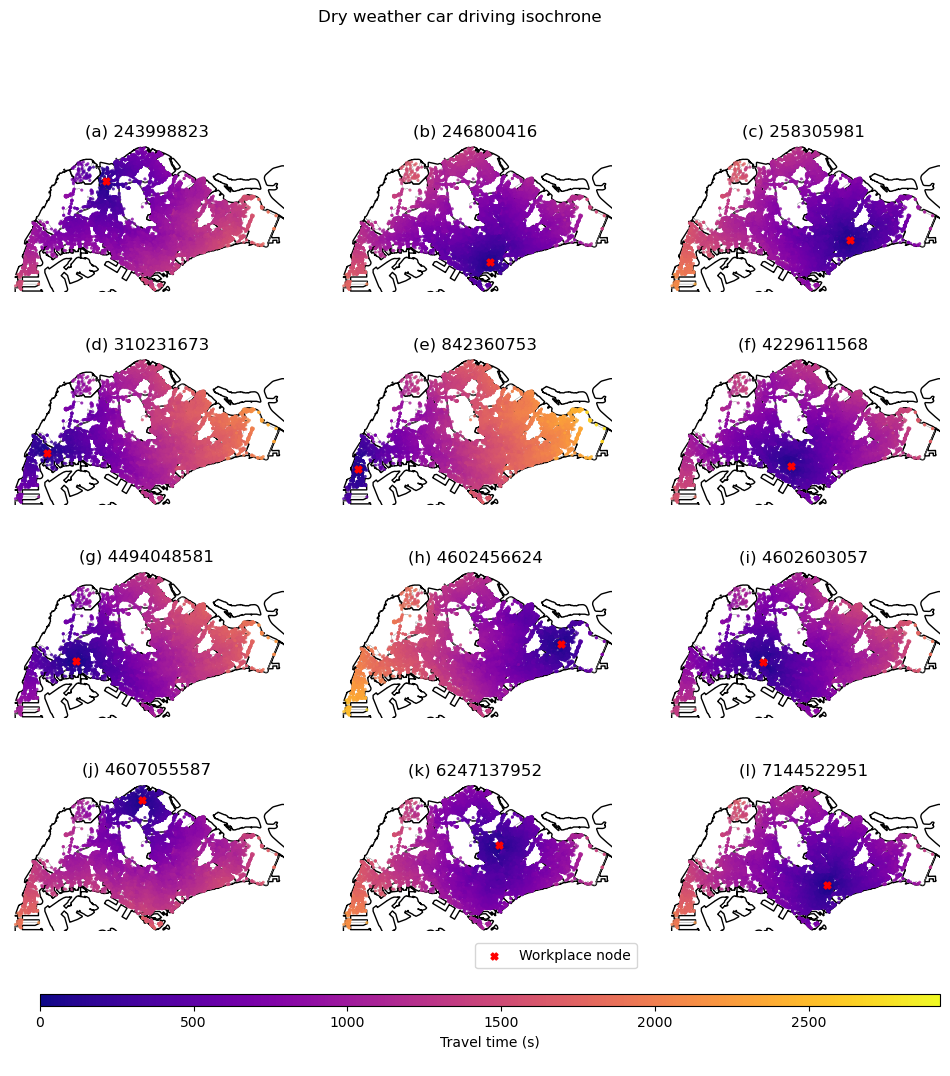

In [ ]:
CT = driving.CarTrip(G_car, workplace_cluster)
car_itinerary_df = CT.get_itinerary_entry(cost="travel_time")

save_fp = os.path.join(r"data\floodRouting","dry_isochrone_car_workClusters.png")
ISO = dryRouting.PlotIsochrone(G_car,car_itinerary_df,planningArea_shp)
ISO.plot_isochrone(flooded_edges=None,column_value="simulated_total_duration",
                   colorbar_label="Travel time (s)", 
                   title="Dry weather car driving isochrone",
                   save_fp=save_fp)

# Bus dry isochrone

### Import public transit json routes

In [62]:
publicTransit_dir = r"D:\PAKHUIYING\publicTransit_busRouting_busLeg_OneMap"
publicTransit_fp_list = [os.path.join(publicTransit_dir,fp) for fp in os.listdir(publicTransit_dir) if not fp.endswith('_ERROR.json')]
print(len(publicTransit_fp_list))
publicTransit_fp_list[:10]

62881


['D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to243998823.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to246800416.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to310231673.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4229611568.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4602456624.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4602603057.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to6247137952.json']

In [66]:
# import one itinerary
itinerary = utils.load_json(publicTransit_fp_list[1])
itinerary

{'busStart': [1.29684825487647, 103.85253591654006, '01012'],
 'workEnd': [1.284440837350969, 103.84295929434434, 246800416],
 'duration': 797,
 'startTime': 1738713644000,
 'endTime': 1738714441000,
 'transitTime': 468,
 'waitingTime': 0,
 'transfers': 0,
 'busLegs': [{'leg_number': 0,
   'duration': 468,
   'distance': 1961.54,
   'startTime': 1738713737000,
   'endTime': 1738714205000,
   'tripId': '2-1-1002',
   'tripDirection': 0,
   'mode': 'BUS',
   'routeId': '2',
   'legGeometry': {'points': 'wi|FswzxRFB`@ZDDJHbDpCrCfCDDn@h@?????@@@vAnAxAn@TJlAh@|Ap@JD\\LJB????@@B@f@PND~DvAVJZJl@TJD\\Nd@TXL????@?@@B@`An@JF^HpCxBx@l@B@????d@^ZT~B~ATRh@`@~@t@tAhAHF@???dA|@pAfA|BdBHF??DB~AnAl@j@d@`@tAdAvAfAhA|@f@`@',
    'length': 71},
   'busLeg': [{'name': 'BRAS BASAH CPLX',
     'stopId': 'FERRY:01019',
     'stopCode': '01019',
     'lon': 103.853022,
     'lat': 1.2969895,
     'arrival': 1738713737000,
     'departure': 1738713737000,
     'stopIndex': 57,
     'stopSequence': 58,
     'ver

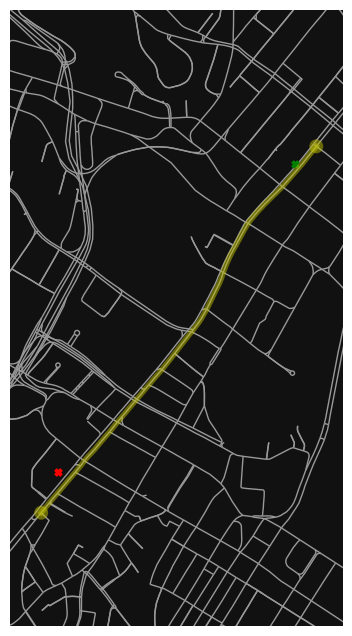

In [61]:
TI = publicTransit.TripItinerary(G_bus, itinerary)
TI.plot_itinerary()

In [71]:
TI = publicTransit.TripItinerary.from_file(G_bus, fp=publicTransit_fp_list[1])
itinerary_entry = TI.get_itinerary_entry()
itinerary_entry

{'start_lat': 1.29684825487647,
 'start_lon': 103.85253591654006,
 'end_lat': 1.284440837350969,
 'end_lon': 103.84295929434434,
 'duration': 797,
 'transitTime': 468,
 'waitingTime': 0,
 'transfers': 0,
 'actual_bus_duration': 468.0,
 'simulated_bus_duration': 123,
 'actual_bus_distance': 1961.54,
 'simulated_bus_distance': 2065,
 'actual_total_duration': 797.0,
 'simulated_total_duration': 452.0,
 'non_bus_duration': 329.0,
 'number_of_busroutes': 1,
 'routeId': '2'}

In [ ]:
noData_file = os.path.join(r'data','error_itineraryEntry_log1.txt')
itinerary_entries = []
for fp in publicTransit_fp_list:
    TI = publicTransit.TripItinerary.from_file(G_bus, fp=fp)
    try:
        itinerary_entry = TI.get_itinerary_entry()
        itinerary_entries.append(itinerary_entry)
    except:
        if not os.path.exists(noData_file):
            with open(noData_file, "w") as myfile:
                myfile.write(f'{fp}\n')

        else:
            with open(noData_file, "a") as myfile:
                myfile.write(f'{fp}\n')

itinerary_df = pd.DataFrame.from_records(itinerary_entries)
# append notes ID to the start and end coordinates
itinerary_df['start_nodesID'] = ox.distance.nearest_nodes(G_bus,X = itinerary_df['start_lon'], Y = itinerary_df['start_lat'])
itinerary_df['end_nodesID'] = ox.distance.nearest_nodes(G_bus,X = itinerary_df['end_lon'], Y = itinerary_df['end_lat'])
# itinerary_df.to_csv(os.path.join(r"data","bus_routing_OneMap.csv"),index=False)
itinerary_df.head()

,start_lat,start_lon,end_lat,end_lon,duration,transitTime,waitingTime,transfers,actual_bus_duration,simulated_bus_duration,actual_bus_distance,simulated_bus_distance,actual_total_duration,simulated_total_duration,non_bus_duration,number_of_busroutes,routeId,start_nodesID,end_nodesID
0,1.296848,103.852536,1.415385,103.751913,4336,2720,627,2,1037.0,321,4800.10,5366,4336.0,3620.0,3299.0,2,"170,925",4748705954,243998823
1,1.296848,103.852536,1.284441,103.842959,797,468,0,0,468.0,123,1961.54,2065,797.0,452.0,329.0,1,2,4748705954,246800416
2,1.296848,103.852536,1.320935,103.894151,1297,560,120,1,87.0,52,624.40,871,1297.0,1262.0,1210.0,1,61,4748705954,258305981
3,1.296848,103.852536,1.320213,103.656895,3530,2822,141,1,87.0,52,624.40,871,3530.0,3495.0,3443.0,1,61,4748705954,310231673
4,1.296848,103.852536,1.299561,103.798223,1806,1060,141,1,87.0,52,624.40,871,1806.0,1771.0,1719.0,1,61,4748705954,4229611568


Split itinerary based on unique end nodes e.g. end_nodesID

In [ ]:
itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap.csv"))
print(len(set(itinerary_master_df['end_nodesID'])))
print(itinerary_master_df.dtypes)
itinerary_df_list = {k:df for k,df in itinerary_master_df.groupby('end_nodesID')}
print(len(list(itinerary_df_list)))
# check if there are workplace nodes not in itinerary df
print(set(list(itinerary_df_list))^set(workplace_cluster['node_ID']))
workplace_cluster.dtypes

12
start_lat                   float64
start_lon                   float64
end_lat                     float64
end_lon                     float64
duration                      int64
transitTime                   int64
waitingTime                   int64
transfers                     int64
actual_bus_duration         float64
simulated_bus_duration        int64
actual_bus_distance         float64
simulated_bus_distance        int64
actual_total_duration       float64
simulated_total_duration    float64
non_bus_duration            float64
number_of_busroutes           int64
routeId                      object
start_nodesID                 int64
end_nodesID                   int64
dtype: object
12


### Plot dry public transit isochrone
- Only itineraries with at least 1 bus route is plotted
- Each subplot represents itinerary to a unique work cluster

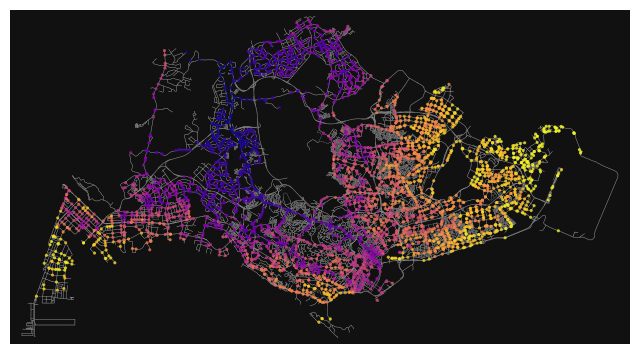

In [273]:
# import dry weather public transit routing
itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap.csv"))
ISO = dryRouting.PlotIsochrone(G_bus,itinerary_master_df,planningArea_shp)
itinerary_df_list = ISO.get_grouped_itinerary_df()
bus_route_times = ISO.plot_shortest_path_route(itinerary_df_list[list(itinerary_df_list)[0]],column_value="actual_total_duration")

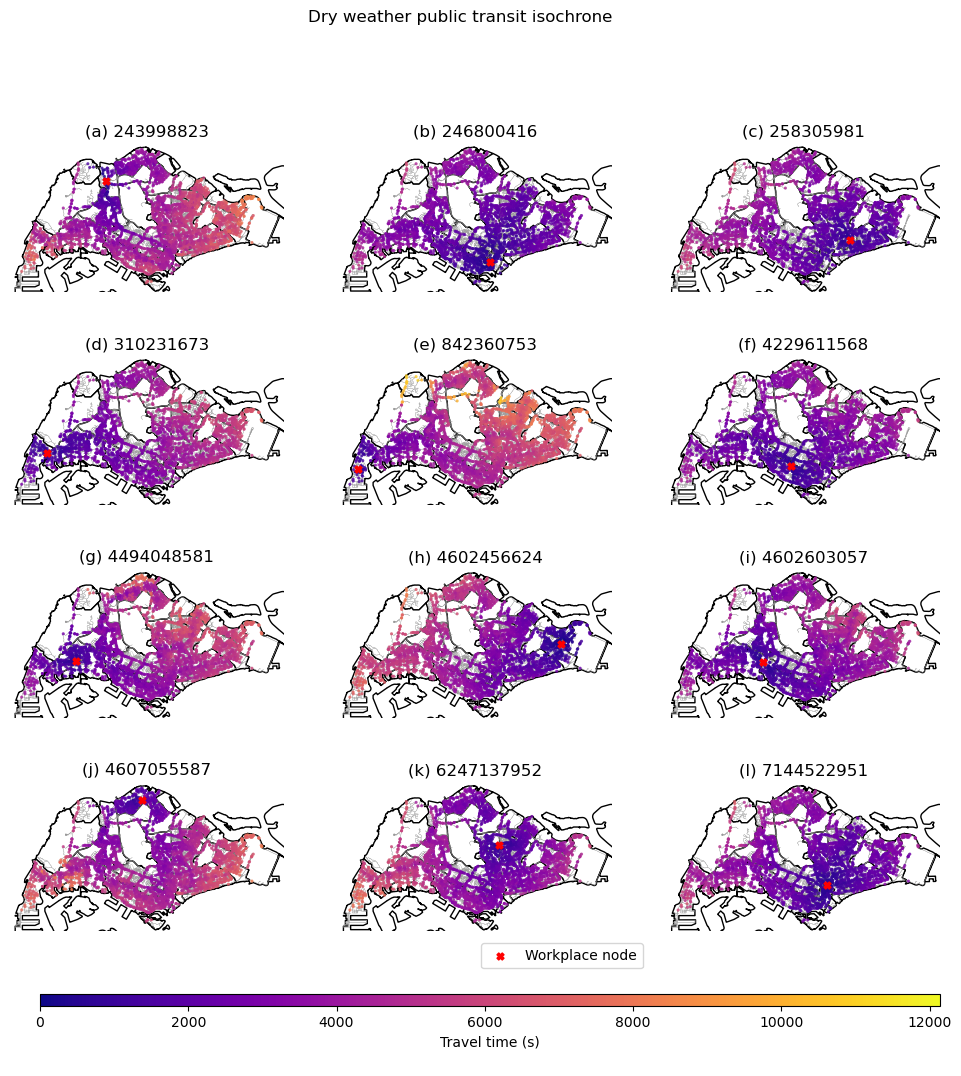

In [ ]:
# import dry weather public transit routing
itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap.csv"))
save_fp = os.path.join(r"data\floodRouting","dry_isochrone_publicTransit_workClusters.png")
ISO = dryRouting.PlotIsochrone(G_bus,itinerary_master_df,planningArea_shp)
ISO.plot_isochrone(flooded_edges=None,column_value="actual_total_duration",
                   colorbar_label="Travel time (s)", 
                   title="Dry weather public transit isochrone",
                   save_fp=save_fp)

TODO: 

#### Raster analysis
- Map raster inundation map over edges in `G_car` and `G_bus`, pixel by pixel (coord by coord), and add the pixel value (i.e. flood depth) as an attribute `flood_depth` to the edges
    - obtain the geographical coordinates of each pixel's centroid (it may be possible that 1 pixel cover multiple roads, so use pixel centroid instead) and their flood depth
    - obtain closest edge (road) based on coords
- Update edges' attributes - `max_speed` and `travel_time` 

#### Vector/point analysis
If there is no raster inundation map, we will just look at the roads that were flooded at these scenarios - 90th, 95th, 99th, and 99.9th percentile for the max 30 mins rainfall
- Use the `precipitation_levels_during_flood_events.csv` to identify all the roads that have been flooded (in recent times e.g. >=2020) for each rainfall type percentile
- identify relevant road edges for each scenario
- Update edges' attributes - `max_speed` and `travel_time` 

**Rerun flood risk analysis for 2014 to 2024**

1. Can we find out which bus sevices are most likely to be impacted?
2. Can we identify the critical road segments that result in the highest time delay?

# Vector impact travel time analysis

### Import historical flood events

In [8]:
historical_floods = pd.read_csv(r"Flood_Weather_Data\precipitation_levels_during_flood_events.csv")
print(historical_floods.dtypes)
historical_floods.head()

flooded_location                  object
responses_found                    int64
matched_location                  object
latitude                         float64
longitude                        float64
closest_weather_stn               object
mean_pr                          float64
daily rainfall total (mm)        float64
highest 30 min rainfall (mm)     float64
highest 60 min rainfall (mm)     float64
highest 120 min rainfall (mm)    float64
drainage_catchment                object
time                              object
dtype: object


,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
0,Yishun MRT,9,ATM DBS YISHUN MRT STATION,1.429525,103.834995,Yishun,17.395082,45.0,40.8,44.0,44.2,Woodlands,2014-03-20
1,2 KAKI BUKIT ROAD 3,1,2 KAKI BUKIT ROAD 3 SINGAPORE 417817,1.337334,103.901943,Tai Seng,7.993548,25.0,21.0,25.0,25.0,Geylang,2014-04-04
2,PSC Building,1,PSC BUILDING,1.328863,103.706189,Boon Lay (West),14.574603,89.5,49.5,83.0,89.0,Jurong,2014-04-23
3,21229 (bus stop),1,21229 (BUS STOP),1.342064,103.716020,Jurong (North),14.574603,65.4,51.6,63.8,65.4,Jurong,2014-04-23
4,Tengah Flyover,1,TENGAH FLYOVER,1.363822,103.707043,Jurong (North),22.195238,92.6,50.2,78.4,92.2,Kranji,2014-05-16


### Import historical weather data

In [7]:
imported_data_dir = os.path.join(os.getcwd(),"Flood_Weather_Data")
percentiles, historical_ppt_percentiles = flood_utils.get_historical_ppt_percentiles(fp=os.path.join(imported_data_dir,"historical_weather.csv"),
                                                                         percentiles=[90,95,99,99.9])
print(percentiles)
print(historical_ppt_percentiles)

[90, 95, 99, 99.9]
{'highest 30 min rainfall (mm)': array([13.8, 21.2, 35.6, 51.4]), 'highest 60 min rainfall (mm)': array([17.    , 26.8   , 47.2   , 70.4767]), 'highest 120 min rainfall (mm)': array([19. , 30.2, 55. , 85. ])}


### Identify flooded roads by rain percentile

TODO:
- convert rainfall percentile values to 1 in ? return period of rainfall. We do not have a 1 in ? year of flood event as pluvial flood drain out pretty fast. PUB does have a drainage code of practice that can handle a 1 in 100 year flood.
- for each derived flooded roads for **rainfall value** and **rainfall type**, update the speed and travel time.
- **Determining travel speed during flooding**: sort travel speed bands in `TravelSpeedBands.*.csv` to obtain the lowest speed band during a rainfall event. Select a representative road and obtain the respective speed band e.g. Ang mo kio ave 4 has speed band 2, which corresponds to *10-19km/h*
- identify critical road segments that needs prioritisation of flood risk reduction (i.e. identify the road segment that creates the highest time delay when flooded)
- identify which roads have the highest likelihood of flood?

- Scenarios analysis:
    - speed changes based on flood depth e.g. [Pregnolato et al (2017)](https://www.sciencedirect.com/science/article/pii/S1361920916308367) proposed a depth-disruption function to estimate a relationship between road inundation depth and traffic disruption based on existing empirical studies. *Note*: Only achievable if we have the flood inundation raster map
    - flood depth > 15 - 40 cm, cars stall, road takes 30 - 60 minutes to drain out water. Minimum delay is the delay that it takes for the water to drain away from the road i.e. at most 1 hour.
    - Train routing, which train stations are the most critical which creates the highest time delay when flooded?

In [47]:
edges = ox.graph_to_gdfs(G_bus, nodes=False)
edges['maxspeed'] = pd.to_numeric(edges['maxspeed'])
edges['travel_time'].describe()

count    45756.000000
mean         9.119024
std         13.027212
min          0.056037
25%          2.012608
50%          4.707734
75%         11.225749
max        313.808033
Name: travel_time, dtype: float64

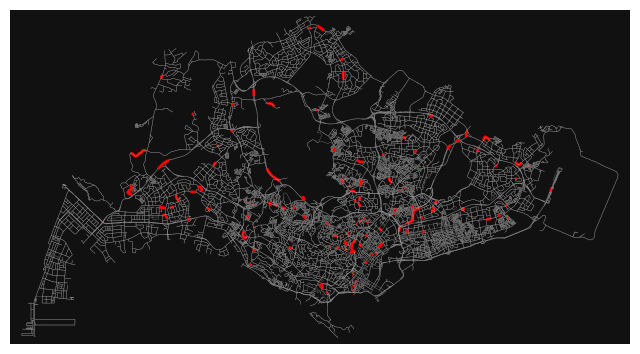

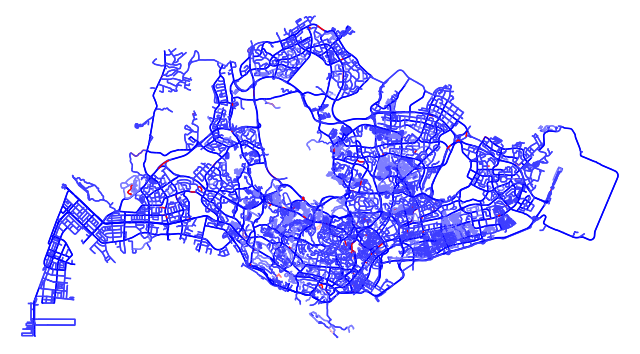

In [124]:
UFN = floodedRouting.UpdateFloodNetwork(G_bus, flooded_maxspeed=5)
# show flooded edges
flooded_edges = UFN.identify_flooded_roads(historical_floods,51,rf_type='highest 30 min rainfall (mm)',plot=True,
                                           flooded_edge_color="red",edge_color="#999999")
# show updated network road speed
UFN.update_flooded_road_network(flooded_edges, cmap="bwr_r",node_size=0,bgcolor="white")

# Compute global flooded roads
1. Compute global flooded roads by considering that multiple roads flood simultaneously

TODO:

2. Compute flooded roads individually to do a sensitivity analysis

### Compute flooded bus itinerary df

In [122]:
save_dir = os.path.join(os.getcwd(),"data","floodRouting")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
# save error data here
noData_file = os.path.join(r'data','error_itineraryEntry_log3.txt')
# parameter inputs
flooded_maxspeed = int(5)
rf_type = 'highest 60 min rainfall (mm)'
rf_perc = 99.9
rf_map = {perc:rf_val for perc, rf_val in zip(percentiles,list(historical_ppt_percentiles[rf_type]))}
rf_value = rf_map[rf_perc]
# save fp
save_fp = os.path.join(save_dir,f"bus_routing_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.csv")

UFN = floodedRouting.UpdateFloodNetwork(G_bus, flooded_maxspeed=flooded_maxspeed)
# itinerary df is derived from identifying flooded roads from historically flooded roads, and update travel speed and time in G
itinerary_df = UFN.get_flooded_publicTransit_df(publicTransit_fp_list,historical_floods,
                                                rf_value,rf_type=rf_type,
                                                save_fp=save_fp,error_fp=noData_file)

### Plot wet weather bus isochrone

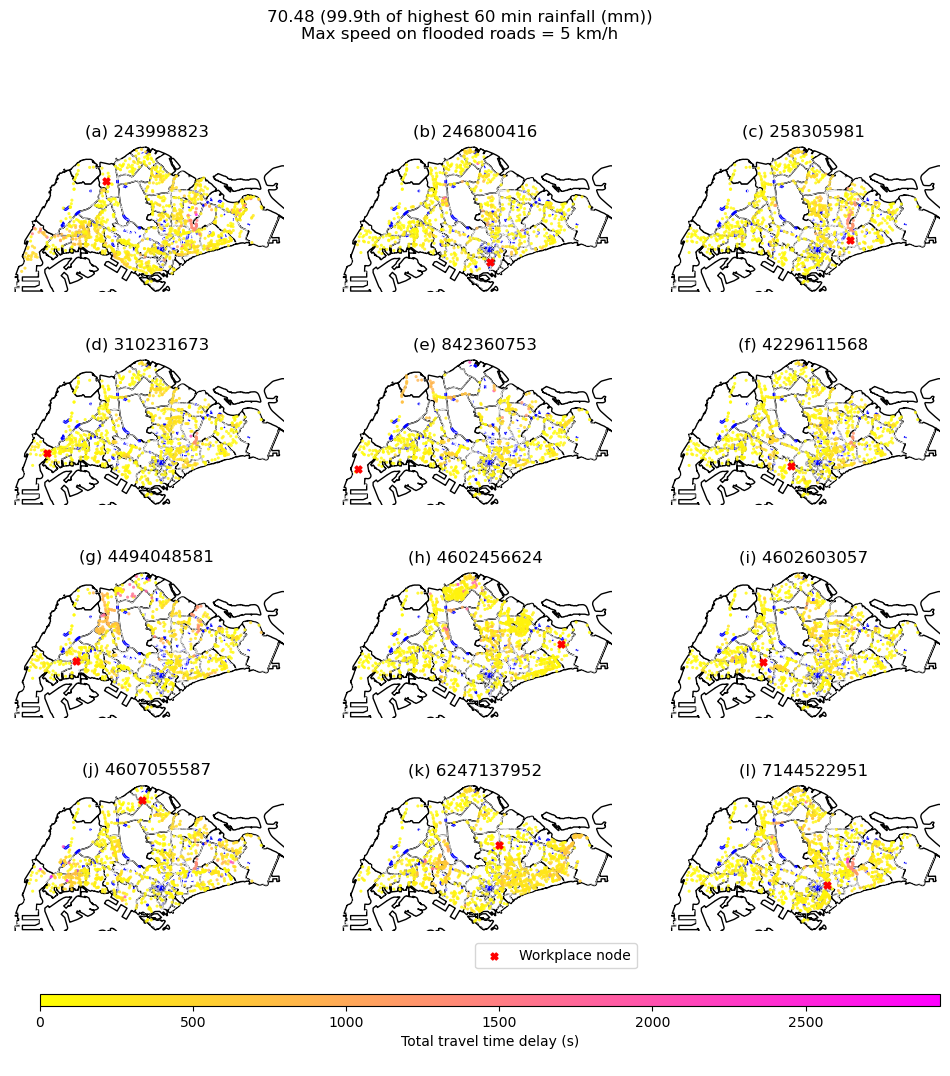

In [268]:
# parameter inputs
flooded_maxspeed = int(5)
rf_type = 'highest 60 min rainfall (mm)'
rf_perc = 99.9
rf_map = {perc:rf_val for perc, rf_val in zip(percentiles,list(historical_ppt_percentiles[rf_type]))}
rf_value = rf_map[rf_perc]
# save fp
save_dir = os.path.join(os.getcwd(),"data","floodRouting")
save_fp = os.path.join(save_dir,f"bus_routing_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
# title from plot
title = f"{rf_value:.2f} ({rf_perc}th of {rf_type})\nMax speed on flooded roads = {flooded_maxspeed} km/h"
# import data
flooded_df = pd.read_csv(os.path.join(save_dir,r"bus_routing_rfTypehighest 30 min rainfall (mm)_rfPerc99.9_maxspeed5.csv"))
dry_df = pd.read_csv(r"data\bus_routing_OneMap.csv")
TTD = floodedRouting.TravelTimeDelay(flooded_df,dry_df,planningArea_shp)
# compute travel time delay by comparing the difference in dry_df and flooded_df
travel_time_delay_df = TTD.compute_travel_time_delay()
ISO = dryRouting.PlotIsochrone(G_bus,travel_time_delay_df,planningArea_shp)
ISO.plot_isochrone(flooded_edges=flooded_edges,column_value="travel_time_delay",
                   cmap="spring_r",flooded_edge_color="blue",
                   colorbar_label="Total travel time delay (s)", title=title,
                   save_fp=save_fp)

c:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\V3 analysis\helper_functions\routing\floodedRouting.py:210: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  route_times = {k: v for k, v in sorted(route_times.items(), key=lambda item: item[1])}


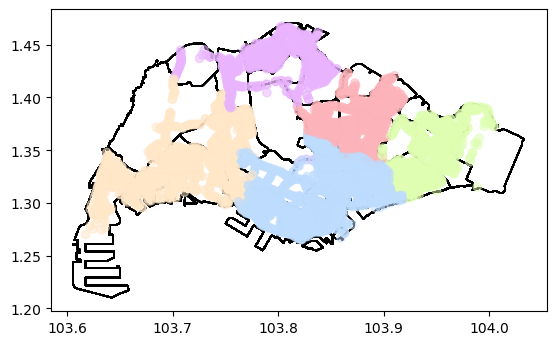

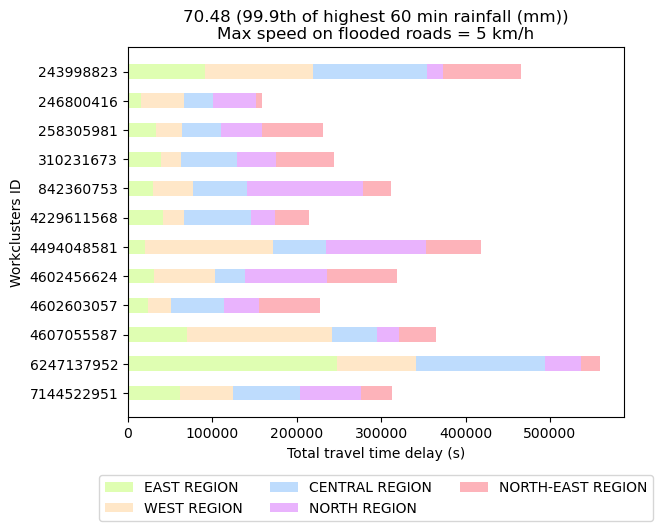

In [274]:
TTD = floodedRouting.TravelTimeDelay(flooded_df,dry_df,planningArea_shp)
TTD.get_planningArea_itinerary(itinerary_df=itinerary_df_list[list(itinerary_df_list)[0]],
                               colors=None,plot=True)
TTD.get_total_travel_time_delay()

# parameter inputs
flooded_maxspeed = int(5)
rf_type = 'highest 60 min rainfall (mm)'
rf_perc = 99.9
rf_map = {perc:rf_val for perc, rf_val in zip(percentiles,list(historical_ppt_percentiles[rf_type]))}
rf_value = rf_map[rf_perc]
# save fp
save_dir = os.path.join(os.getcwd(),"data","floodRouting")
save_fp = os.path.join(save_dir,f"barPlot_bus_routing_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
# title from plot
title = f"{rf_value:.2f} ({rf_perc}th of {rf_type})\nMax speed on flooded roads = {flooded_maxspeed} km/h"
TTD.plot_total_travel_time_delay(title=title,save_fp=save_fp)

TODO:
- refactoring of code for private car transport by converting travel time to a dataframe for consistency in analysis for both private and public transit
- compute statistics for travel time delay per planning area